# Performing NER and Sentimental Analysis on Elections related articles of The Hindu

In [1]:
# Import necessary packages
import nltk
from nltk.tokenize import word_tokenize, regexp_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk.text import TextCollection
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

import spacy
from spacy import displacy
from collections import Counter
nlp = spacy.load("en_core_web_sm")

from matplotlib import pyplot as plt
import seaborn as sb
%matplotlib inline
import pandas as pd
import numpy as np

from pprint import pprint
from pymongo import MongoClient

## Fetching the articles belonging to relevant collection

In [2]:
# fetch the article collection
client = MongoClient()
db = client["TheHindu"]
col = db['elections']
article = []
for item in col.find():
    article.append(item['content'])
print('Number of articles found:', len(article))

Number of articles found: 53


In [3]:
# Basic exploration
corpus = ' '.join(article)
stoplist = stopwords.words('english')
tokens = [token for token in regexp_tokenize(corpus, '\w+') if len(token) > 1 and not token.isdigit() and token.lower() not in stoplist]
freqdist = nltk.FreqDist(tokens)
print('Total number of tokens found:', len(freqdist))

Total number of tokens found: 5322


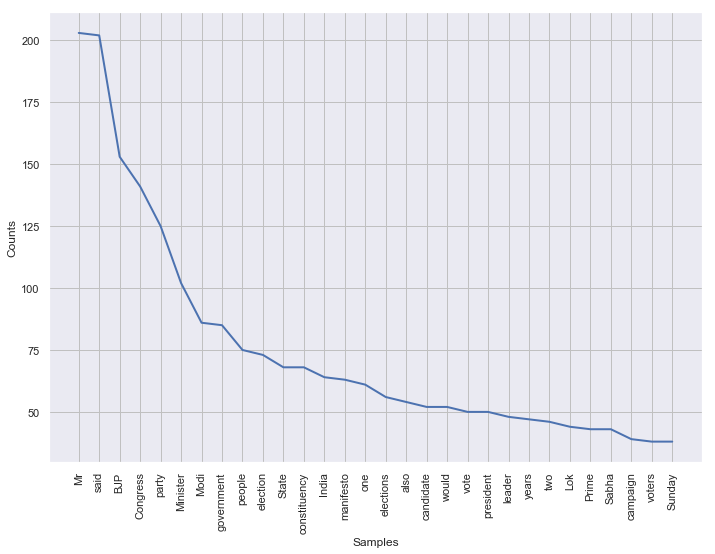

In [4]:
sb.set(rc={'figure.figsize':(11.7,8.27)})
freqdist.plot(30)

## Demonstrating NER on a single article using Spacy

In [5]:
# perform ner on each article
print(article[0])

PM Modi speaking at a meeting in Amroha.   | Photo Credit: 
PTI Prime Minister Narendra Modi on Friday referred to the AgustaWestland chopper case at an election rally, saying the top Congress leadership received kickbacks in the UPA-era purchase. Addressing an election rally at the Parade Ground here, Mr. Modi also accused the Congress of being soft on Pakistan. “Agencies have investigated persons we brought back from Dubai. On that basis a chargesheet has been filed. I saw in the media that the persons who received kickbacks in the case and are mentioned in the charge sheet are ‘AP’ and ‘FAM’. The same chargesheet mentions ‘AP’ means Ahmed Patel and ‘FAM’ means family,” Mr. Modi said. Mr. Modi was addressing a rally in Dehra Dun for the Tehri Garhwal seat where Mala Rajya Laxmi Shah, BJP’s sitting MP has been re-nominated. The Prime Minister referred to alleged middleman Christian Michel, who was extradited from Dubai, and said he was revealing secrets of the “helicopter scam”. Mr. M

In [6]:
displacy.render(nlp(article[0]), jupyter=True, style='ent')

## Perfroming NER to find Named Entities in a corpus. Results are narrowed down to Persons, Organizations and GeoPolitical Entities only.

In [7]:
def getNE(text):
    ne = {}
    for x in nlp(text).ents:
        entity, label = x.text.strip(), x.label_
        if(label in ['GPE', 'PERSON', 'ORG'] and len(entity) > 1 and entity.lower() not in stoplist):
            ne[entity] = label
    return ne

In [8]:
getNE(corpus)

{'Amroha': 'GPE',
 'Narendra Modi': 'PERSON',
 'AgustaWestland': 'ORG',
 'Congress': 'ORG',
 'Modi': 'PERSON',
 'Pakistan': 'GPE',
 'Dubai': 'GPE',
 'AP': 'ORG',
 'FAM': 'ORG',
 'Ahmed Patel': 'PERSON',
 'Dehra Dun': 'PERSON',
 'Tehri Garhwal': 'ORG',
 'Mala Rajya Laxmi Shah': 'PERSON',
 'BJP’s': 'ORG',
 'Christian Michel': 'PERSON',
 'Opposition': 'ORG',
 'AFSPA': 'ORG',
 'Uttarakhand': 'GPE',
 'State': 'ORG',
 'Rank One Pension': 'ORG',
 'OROP': 'ORG',
 'Tejasvi Surya': 'PERSON',
 'Janata Party’s': 'ORG',
 'Bengaluru South': 'PERSON',
 '’m': 'ORG',
 'ABVP': 'ORG',
 'BJP': 'ORG',
 'Jayanagar': 'ORG',
 'Constitutional': 'ORG',
 'anti-India': 'GPE',
 'India': 'GPE',
 'the Karnataka State Commission for Women': 'ORG',
 'N. Chandrababu Naidu': 'PERSON',
 'Kuppam': 'ORG',
 'Karnataka': 'GPE',
 'Tamil Nadu': 'ORG',
 'Andhra': 'GPE',
 'MLA': 'ORG',
 'Nara Chandrababu Naidu': 'PERSON',
 '’s': 'ORG',
 'Chandrababu Naidu': 'PERSON',
 'Ramakuppam': 'GPE',
 'Gudupalle': 'GPE',
 'Shantipuram': 'OR

## Performing sentimental analysis for each entity detected in all the articles. The method also involves checking upto 3 sentences ahead if the entity is found in a sentence, to include the further sentences with pronouns for the same entity.

In [9]:
# loop through the sentences containing each NER can calculate the sentiment score and average it.
def getSentimentScore(term, corpus):
    sia = SentimentIntensityAnalyzer()
    scores = []
    sentences = sent_tokenize(corpus)
    weights = [1, 0.75, 0.5, 0.25]
    for i in range(len(sentences)):
        sentence = sentences[i]
        if term in sentence:
            scores.append(sia.polarity_scores(sentence)['compound'])
            x = i+1
            while(x < len(sentences) and x-i <= 3):
                if term in sentences[x]:
                    break
                for word, tag in pos_tag(word_tokenize(sentences[x])):
                    if tag in ['PRP', 'PRP$']:
                        scores.append(sia.polarity_scores(sentences[x])['compound'] * weights[x-i])
                        break
                x += 1

    avg_sent_score = round(sum(scores)/len(scores), 5) if len(scores)>0 else 0
    return avg_sent_score

In [10]:
# organising the enities and their scores in a dictionary on the base of entity types
nes = getNE(corpus)
sent_scores = {}
for ne in nes:
    ne_tag = nes[ne]
    if ne_tag not in sent_scores:
        sent_scores[ne_tag] = []
    sent_scores[ne_tag].append((ne, getSentimentScore(ne, corpus)))

In [11]:
# Sorting the entities in increasing order of sentiment score.
for ne_tag in sent_scores:
    sent_scores[ne_tag] = sorted(sent_scores[ne_tag], key=lambda x: x[1])

In [12]:
pprint(sent_scores)

{'GPE': [('Dhamsalapuram', -0.3592),
         ('Coochbehar', -0.29167),
         ('Logon', -0.24827),
         ('Lakshmipur', -0.2202),
         ('Pulwama', -0.20692),
         ('Koppal', -0.15325),
         ('Himanshu', -0.13531),
         ('Leukoplast', -0.13195),
         ('Aandhi', -0.1079),
         ('Gurazala', -0.09405),
         ('anti-India', -0.08569),
         ('Bollapalli', -0.08333),
         ('Vinukonda', -0.08333),
         ('Katpadi', -0.08133),
         ('Ayudha Puja', -0.07779),
         ('Assam', -0.06474),
         ('Karnataka', -0.05434),
         ('Narsaraopet', -0.05135),
         ('Saurashtra', -0.03772),
         ('Shivaji Park', -0.03762),
         ('Dadar', -0.03762),
         ('Chitradurga', -0.037),
         ('Mangaluru', -0.037),
         ('Ugadi', -0.02895),
         ('Mylapore', -0.02125),
         ('Balakot', -0.00901),
         ('Mumbai North West', -0.00433),
         ('Bengaluru', -0.00265),
         ('Amroha', 0.0),
         ('₹29', 0.0),
         (

In [13]:
print('Total NE detected:')
for ne_tag in sent_scores:
    print('{}: {}'.format(ne_tag, len(sent_scores[ne_tag])))

Total NE detected:
GPE: 133
PERSON: 490
ORG: 347


## Plotting the top and bottom N entities on the basis of sentiment score rankings.

In [14]:
def plotSentScores(data, n, features):
    if n>0:
        df = pd.DataFrame(data[-n:], columns=features)
        sb.barplot(data=df, y=features[0], x=features[1], orient='h', color='green')
    elif(n<0):
        df = pd.DataFrame(data[:abs(n)], columns=features)
        sb.barplot(data=df, y=features[0], x=features[1], orient='h', color='red')

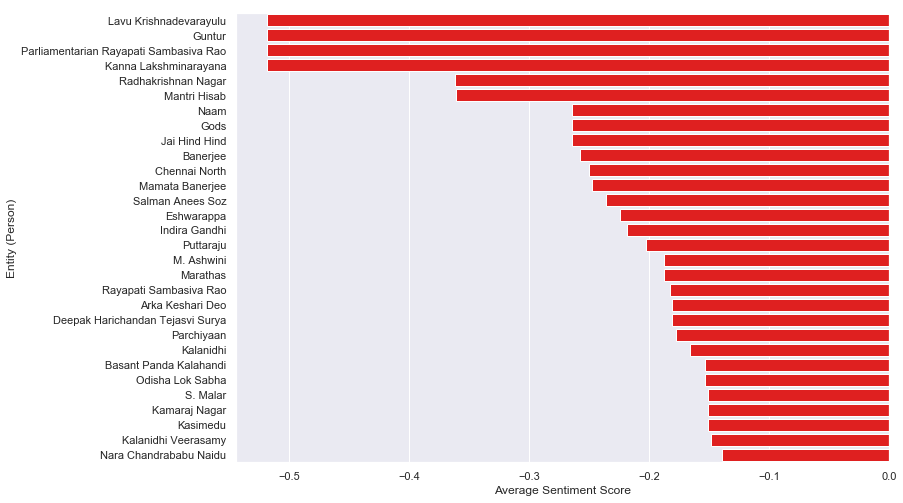

In [15]:
plotSentScores(sent_scores['PERSON'], -30, ['Entity (Person)', 'Average Sentiment Score'])

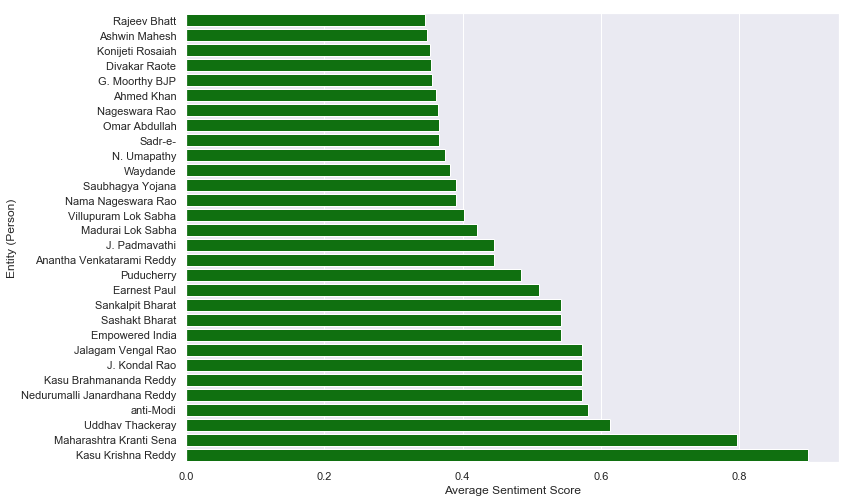

In [16]:
plotSentScores(sent_scores['PERSON'], 30, ['Entity (Person)', 'Average Sentiment Score'])

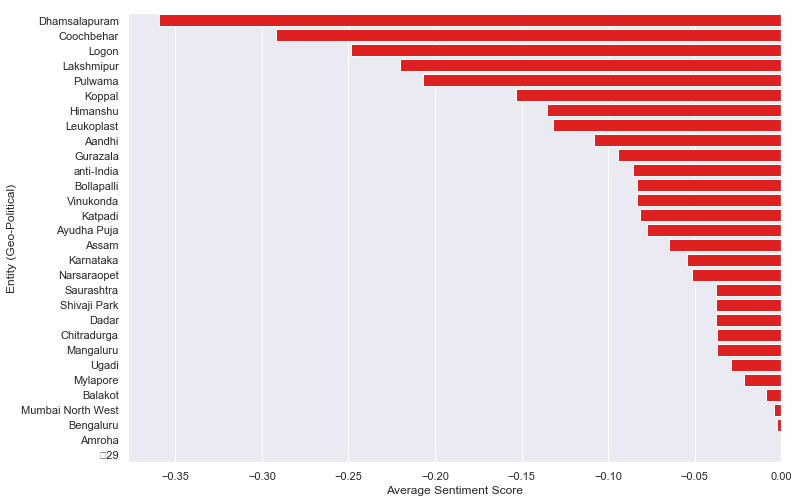

In [17]:
plotSentScores(sent_scores['GPE'], -30, ['Entity (Geo-Political)', 'Average Sentiment Score'])

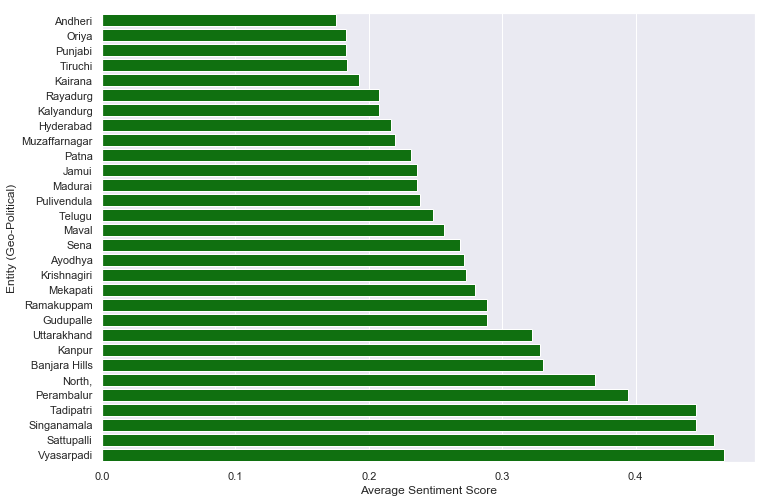

In [18]:
plotSentScores(sent_scores['GPE'], 30, ['Entity (Geo-Political)', 'Average Sentiment Score'])

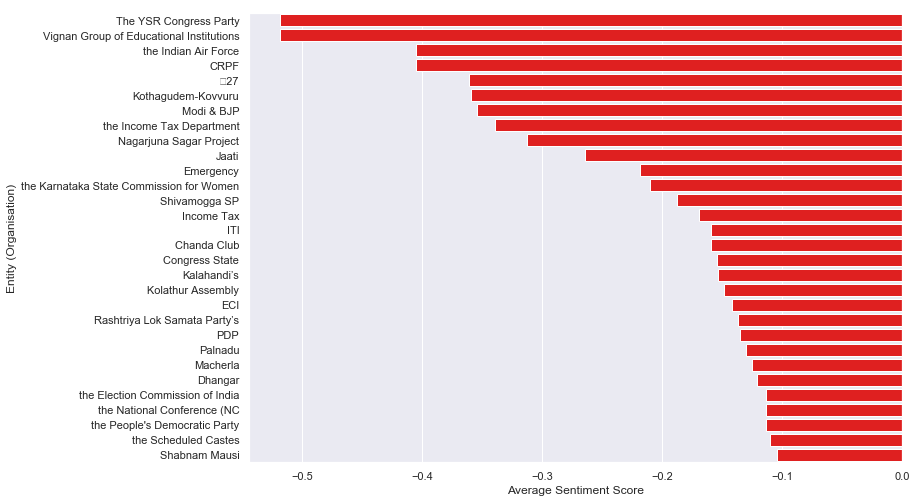

In [19]:
plotSentScores(sent_scores['ORG'], -30, ['Entity (Organisation)', 'Average Sentiment Score'])

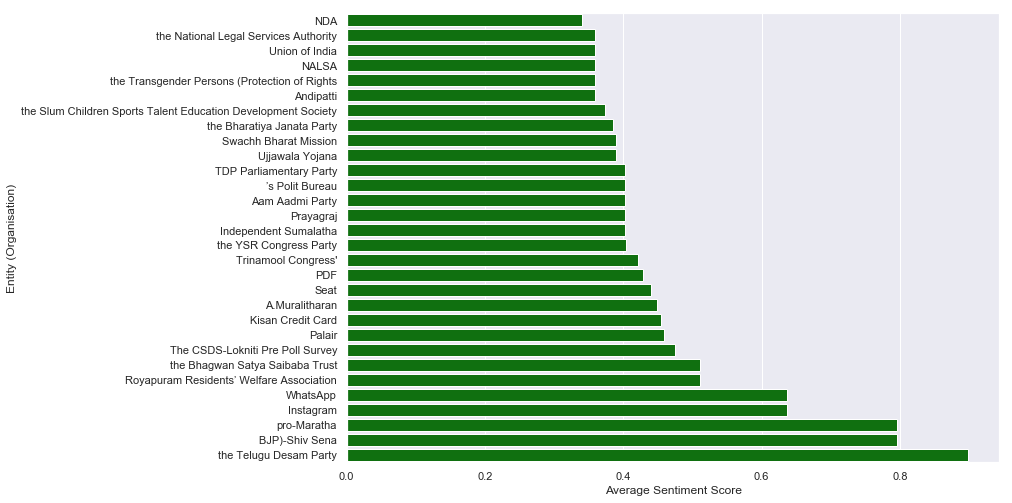

In [20]:
plotSentScores(sent_scores['ORG'], 30, ['Entity (Organisation)', 'Average Sentiment Score'])